In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


# **🌟 Join me on my journey! 🌟**
I've documented my experiences, insights, and lessons learned throughout this competition in [my medium blog post](https://medium.com/@samiraalipour). Discover the strategies that helped me tackle challenges and achieve results!

# **Binary Prediction of Poisonous Mushrooms**

The goal of this competition is to predict whether a mushroom is edible or poisonous based on its physical characteristics.

Submissions are evaluated using the Matthews correlation coefficient (MCC).

# **Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [UCI Mushroom dataset](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset). Feature distributions are close to, but not exactly the same, as the original.

Original Dataset:
The given information is about the Secondary Mushroom Dataset, the Primary Mushroom Dataset used for the simulation and the respective metadata can be found in the zip.

This dataset includes 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms
per species). Each mushroom is identified as definitely edible, definitely poisonous, or of
unknown edibility and not recommended (the latter class was combined with the poisonous class).

The related Python project contains a Python module secondary_data_generation.py
used to generate this data based on primary_data_edited.csv also found in the repository.
Both nominal and metrical variables are a result of randomization.
The simulated and ordered by species version is found in secondary_data_generated.csv.
The randomly shuffled version is found in secondary_data_shuffled.csv.

It has 22 attributes, as below mentioned:

1. cap-diameter (m): float number in cm
2. cap-shape (n): bell=b, conical=c, convex=x, flat=f,
sunken=s, spherical=p, others=o
3. cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s,
shiny=h, leathery=l, silky=k, sticky=t,
wrinkled=w, fleshy=e
4. cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p,
purple=u, red=e, white=w, yellow=y, blue=l,
orange=o, black=k
5. does-bruise-bleed (n): bruises-or-bleeding=t,no=f
6. gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e,
sinuate=s, pores=p, none=f, unknown=?
7. gill-spacing (n): close=c, distant=d, none=f
8. gill-color (n): see cap-color + none=f
9. stem-height (m): float number in cm
10. stem-width (m): float number in mm
11. stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e,
rhizomorphs=z, rooted=r
12. stem-surface (n): see cap-surface + none=f
13. stem-color (n): see cap-color + none=f
14. veil-type (n): partial=p, universal=u
15. veil-color (n): see cap-color + none=f
16. has-ring (n): ring=t, none=f
17. ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g,
large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
18. spore-print-color (n): see cap color
19. habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h,
urban=u, waste=w, woods=d
20. season (n): spring=s, summer=u, autumn=a, winter=w
21. class: edible=e, poisonous=p

In [2]:
!pip install ucimlrepo

In [3]:
# Import Libraries

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import string
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures,StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import  KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import gc


import warnings
warnings.filterwarnings("ignore")

In [4]:
from ucimlrepo import fetch_ucirepo 
   
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
X_original = secondary_mushroom.data.features 
y_original = secondary_mushroom.data.targets 
  
# metadata 
print(secondary_mushroom.metadata) 
  
# variable information 
print(secondary_mushroom.variables) 


{'uci_id': 848, 'name': 'Secondary Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/848/data.csv', 'abstract': 'Dataset of simulated mushrooms for binary classification into edible and poisonous.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 61068, 'num_features': 20, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2021, 'last_updated': 'Wed Apr 10 2024', 'dataset_doi': '10.24432/C5FP5Q', 'creators': ['Dennis Wagner', 'D. Heider', 'Georges Hattab'], 'intro_paper': {'title': 'Mushroom data creation, curation, and simulation to support classification tasks', 'authors': 'Dennis Wagner, D. Heider, Georges Hattab', 'published_in': 'Scientific Reports', 'year': 2021, 'url': 'https://www.semanticscholar.org/

In [5]:
original_data = X_original.copy()
original_data['class'] = y_original

In [6]:
print('Shape of original data is : ' , original_data.shape)
original_data.head(5)

Shape of original data is :  (61069, 21)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,...,y,w,u,w,t,g,NaN,d,w,p
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,...,y,w,u,w,t,g,NaN,d,u,p
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,...,y,w,u,w,t,g,NaN,d,w,p
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,...,y,w,u,w,t,p,NaN,d,w,p
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,...,y,w,u,w,t,p,NaN,d,w,p


In [7]:
original_data.columns

Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season', 'class'],
      dtype='object')

In [8]:
#Loading the Dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')


print('Shape of train data is : ' , train_data.shape)
print('train data columns: ' , train_data.columns)

Shape of train data is :  (3116945, 22)
train data columns:  Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')


In [9]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [10]:
train_data = train_data.drop(['id'] , axis=1)

print('Shape of train data is : ' , train_data.shape)

Shape of train data is :  (3116945, 21)


In [11]:
train_data = pd.concat([train_data, original_data], ignore_index=True)
print('Shape of original data is : ' , train_data.shape)

Shape of original data is :  (3178014, 21)


# **Check & handle duplication**

In [12]:
duplicated_rows = train_data.duplicated()
sum(duplicated_rows)

146

In [13]:
# Remove duplicates
train_data = train_data.drop_duplicates().reset_index(drop=True)
duplicated_rows = train_data.duplicated()
sum(duplicated_rows)

0

# **Data Exploration**

In [14]:
#some information about the attributes(datatypes & null values)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3177868 entries, 0 to 3177867
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 509.1+ MB


In [15]:
train_data.isna().sum()

class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              685143
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          533791
gill-spacing            1283497
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2808559
stem-surface            2018983
stem-color                   38
veil-type               3015239
veil-color              2794457
has-ring                     24
ring-type                131351
spore-print-color       2904279
habitat                      45
season                        0
dtype: int64

In [16]:
#Check statistical information of numerical values

numerical_features = train_data.select_dtypes(include=[np.number])
train_data.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3177864.0,6.318132,4.670760,0.03,3.32,5.75,8.25,80.67
stem-height,3177868.0,6.353104,2.714107,0.00,4.67,5.88,7.41,88.72
stem-width,3177868.0,11.173430,8.138109,0.00,4.98,9.66,15.65,103.91


In [17]:
#Check statistical information of categorical values

categorial_features = train_data.select_dtypes(include=object)
train_data.describe(include=object)

,class,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
count,3177868,3177828,2492725,3177856,3177860,2644077,1894371,3177811,369309,1158885,3177830,162629,383411,3177844,3046517,273589,3177823,3177868
unique,2,74,83,78,26,78,48,63,38,60,59,22,24,23,40,32,52,4
top,p,x,t,n,f,a,c,w,b,s,w,u,w,f,f,k,d,a
freq,1739138,1462958,468961,1383747,2620076,658731,1355736,950030,168978,333635,1219563,162550,284544,2414576,2525385,109428,2221636,1573462


In [18]:
# Get the number of unique values for each column
unique_counts = train_data.nunique()
print(unique_counts)

class                      2
cap-diameter            3914
cap-shape                 74
cap-surface               83
cap-color                 78
does-bruise-or-bleed      26
gill-attachment           78
gill-spacing              48
gill-color                63
stem-height             2758
stem-width              5936
stem-root                 38
stem-surface              60
stem-color                59
veil-type                 22
veil-color                24
has-ring                  23
ring-type                 40
spore-print-color         32
habitat                   52
season                     4
dtype: int64


In [19]:
# Set a threshold for the maximum number of unique values to display frequencies
threshold = 100

# Dictionary to hold value frequencies
value_frequencies = {}

# Iterate over columns to compute value frequencies
for col in train_data.columns:
    if unique_counts[col] <= threshold:
        value_counts = train_data[col].value_counts()
        value_frequencies[col] = value_counts

# Print the value frequencies for columns with fewer unique values
for col, frequencies in value_frequencies.items():
    print(f"Column '{col}':")
    print(f"Number of unique values: {unique_counts[col]}")
    print("Value frequencies:")
    print(frequencies)
    print()

Column 'class':
Number of unique values: 2
Value frequencies:
class
p    1739138
e    1438730
Name: count, dtype: int64

Column 'cap-shape':
Number of unique values: 74
Value frequencies:
cap-shape
x        1462958
f         689642
s         372310
b         324340
o         112151
          ...   
12.62          1
5.15           1
19.04          1
49.21          1
19.06          1
Name: count, Length: 74, dtype: int64

Column 'cap-surface':
Number of unique values: 83
Value frequencies:
cap-surface
t        468961
s        392550
y        334167
h        289434
g        268451
          ...  
1.42          1
has h         1
10.83         1
8.96          1
0.87          1
Name: count, Length: 83, dtype: int64

Column 'cap-color':
Number of unique values: 78
Value frequencies:
cap-color
n             1383747
y              395168
w              387091
g              215137
e              201325
               ...   
3.95                1
6.59                1
5.25                1
veil-

# **Data Cleaning**

In [20]:

# Define categorical features and columns to exclude
categorial_features = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
exclude_columns = ['class']

# Create cat_cols, ensuring they exist in both train and test data
cat_cols = [col for col in categorial_features if col not in exclude_columns and col in train_data.columns and col in test_data.columns]

# Initialize dictionaries to store value frequencies, differences, and indices
value_frequencies_train = {}
value_frequencies_test = {}
unique_in_train_not_in_test = {}
indices_unique_in_train_not_in_test = {}

# Initialize a set to collect all unique indices
all_unique_indices = set()

# Loop through specified columns to get value frequencies and unique values
for col in cat_cols:
    # Calculate value frequencies in train
    value_frequencies_train[col] = train_data[col].value_counts()

    # Calculate value frequencies in test (ensure column exists)
    if col in test_data.columns:
        value_frequencies_test[col] = test_data[col].value_counts()
    else:
        value_frequencies_test[col] = pd.Series()

    # Find unique values in train but not in test
    unique_values = set(train_data[col].unique()) - set(test_data[col].unique())
    unique_in_train_not_in_test[col] = unique_values

    # Find indices of samples with these unique values in train set
    if unique_values:
        indices = train_data[train_data[col].isin(unique_values)].index.tolist()
        indices_unique_in_train_not_in_test[col] = indices
        all_unique_indices.update(indices)  # Add these indices to the set

# Convert set to list to get all unique indices
all_unique_indices_list = list(all_unique_indices)

# Print results for the specified columns
for col in cat_cols:
    if unique_in_train_not_in_test[col]:
        print(f"Column '{col}':")
        print(f"Values in train but not in test: {unique_in_train_not_in_test[col]}")
        print(f"Indices of samples with these unique values in train:")
        print(indices_unique_in_train_not_in_test[col])
        print()

# Print all unique indices across specified categorical features
print("\nAll indices of samples with unique categorical values in train but not in test:")
print(all_unique_indices_list)


Column 'cap-shape':
Values in train but not in test: {'4.3', '54.78', '12.62', '3 x', '2.94', '3.37', 'b f', 'is s', '8.29', '20.25', '2.85', '0.82', '17.44', '10.13', '2.77', '19.04', '19.06', '2.63', '10.46', '4.22', '6.53', '19.29', '49.21', '3.52', '21.56', '3.91', '24.16', '4.33', '9.13', '7.41', '3.55', '6.44', '6 x', '7.6', '7 x', '1.66', '3.6', '3.25', '6.21', '7.43', '11.12', '4.97', 'is p', '2.82', '3.04', '5.15'}
Indices of samples with these unique values in train:
[101724, 171144, 194012, 232795, 251036, 299746, 378766, 386370, 623190, 636413, 878364, 878945, 923988, 1068551, 1224104, 1320648, 1354942, 1376770, 1468238, 1491517, 1505130, 1521376, 1566268, 1643679, 1759745, 1784116, 1792242, 1877022, 1886265, 1933776, 1956788, 2014261, 2094049, 2098217, 2123448, 2441394, 2525120, 2607343, 2692596, 2725932, 2752463, 2803615, 2804645, 2851450, 2905239, 2922701, 2924245, 3012094, 3106864]

Column 'cap-surface':
Values in train but not in test: {'2.92', 'is y', '4.66', 'is h', 

In [21]:
unique_indices_count = len(all_unique_indices_list)
print(f"Count of samples with unique categorical values in train but not in test: {unique_indices_count}")


train_data = train_data.drop(all_unique_indices_list).reset_index(drop=True)

Count of samples with unique categorical values in train but not in test: 460


In [22]:
# Extract test_ids for later use
test_ids = test_data['id']
test_data = test_data.drop(columns=['id'], axis=1)

In [23]:
def impute_noise_with_mode(df):
    """Impute non-single alphabet values with mode, excluding nulls."""
    for column in df.select_dtypes(include='object').columns:
        valid_mask = df[column].apply(lambda x: isinstance(x, str) and len(x) == 1 and x in string.ascii_letters)
        mode_value = df.loc[valid_mask, column].mode().iloc[0] if valid_mask.any() else None
        if mode_value:
            df.loc[~valid_mask & df[column].notnull(), column] = mode_value
    return df

def impute_low_frequency_with_mode(train_df, test_df, threshold=10):
    """Impute low-frequency values with mode."""
    for column in train_df.select_dtypes(include='object').columns:
        if column == 'class':
            continue
        value_counts = train_df[column].value_counts()
        mode_value = value_counts.index[0]
        low_freq_values = value_counts.index[value_counts < threshold]
        train_df[column] = train_df[column].replace(low_freq_values, mode_value)
        test_df[column] = test_df[column].replace(dict.fromkeys(low_freq_values, mode_value))
    return train_df, test_df

def impute_nulls(train_df, test_df):
    """Impute null values."""
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    num_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
    cat_columns = train_df.select_dtypes(include=['object']).columns

    # Exclude 'class' column from imputation
    cat_columns = [col for col in cat_columns if col != 'class']

    if len(num_columns) > 0:
        train_df[num_columns] = num_imputer.fit_transform(train_df[num_columns])
        test_df[num_columns] = num_imputer.transform(test_df[num_columns])

    if len(cat_columns) > 0:
        train_df[cat_columns] = cat_imputer.fit_transform(train_df[cat_columns])
        test_df[cat_columns] = cat_imputer.transform(test_df[cat_columns])

    return train_df, test_df

# Apply the functions to train and test data
print("Imputing noise with mode...")
train_data = impute_noise_with_mode(train_data)
test_data = impute_noise_with_mode(test_data)

print("Imputing low-frequency values with mode...")
train_data, test_data = impute_low_frequency_with_mode(train_data, test_data)

print("Imputing null values...")
train_data, test_data = impute_nulls(train_data, test_data)

# Print summary of missing values after processing
print("\nMissing values in train_data after processing:")
print(train_data.isnull().sum())

print("\nMissing values in test_data after processing:")
print(test_data.isnull().sum())

# Print data info
print("\nTrain data info:")
train_data.info()

print("\nTest data info:")
test_data.info()


Imputing noise with mode...
Imputing low-frequency values with mode...
Imputing null values...

Missing values in train_data after processing:
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64

Missing values in test_data after processing:
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width       

# **Plots**

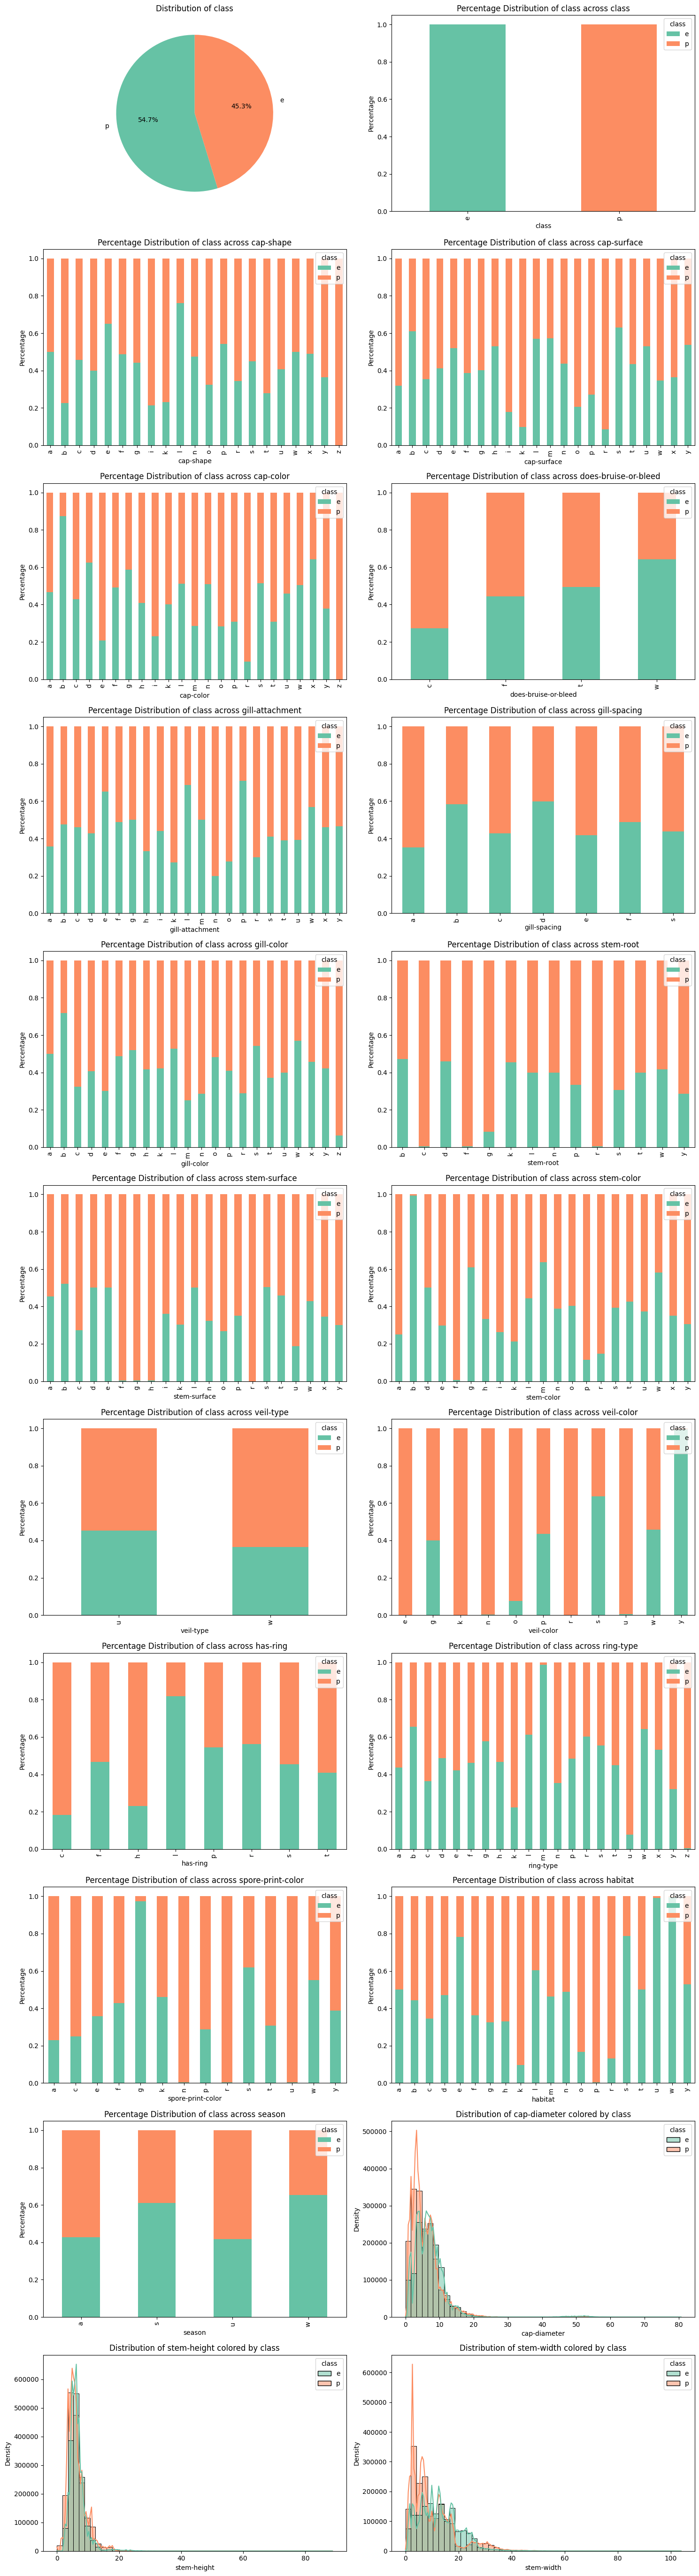

In [24]:
def plot_feature_distributions(data, target):
    cat_cols = [col for col in data.columns if data[col].dtype == 'O' or data[col].nunique() < 100 and col != target]
    num_cols = [col for col in data.columns if col not in cat_cols and col != target]

    # Number of subplots including the pie chart for the target column
    total_plots = len(cat_cols) + len(num_cols) + 1  # +1 for the pie chart
    n_cols = 2
    n_rows = int(np.ceil(total_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()

    # Plot pie chart for the target variable
    target_counts = data[target].value_counts(normalize=True)
    axes[0].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62'], startangle=90)
    axes[0].set_title(f"Distribution of {target}")
    
    # Loop through categorical columns
    for idx, col in enumerate(cat_cols):
        contingency_table = pd.crosstab(data[col], data[target], normalize='index')
        contingency_table.plot(kind="bar", stacked=True, color=['#66c2a5', '#fc8d62'], ax=axes[idx+1])  # +1 to account for the pie chart
        axes[idx+1].set_title(f"Percentage Distribution of {target} across {col}")
        axes[idx+1].set_xlabel(col)
        axes[idx+1].set_ylabel("Percentage")
        axes[idx+1].legend(title=target, loc='upper right')

    # Loop through numerical columns
    for idx, col in enumerate(num_cols, start=len(cat_cols) + 1):  # +1 to account for the pie chart
        # Check skewness and compressed to axis condition
        if data[col].dtype != 'O' and skew(data[col]) > 0.75:
#         # Special case for 'Annual_Premium'
#         if col == 'Annual_Premium':
            sns.histplot(data=data, x=col, hue=target, kde=True, ax=axes[idx], palette=['#66c2a5', '#fc8d62'], bins=50, kde_kws={'bw_adjust': 0.5})
        else:
            sns.histplot(data=data, x=col, hue=target, kde=True, ax=axes[idx], palette=['#66c2a5', '#fc8d62'], bins='auto', kde_kws={'bw_adjust': 0.5})

        axes[idx].set_title(f"Distribution of {col} colored by {target}")
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel("Density")

    # Remove any extra empty plots if the number of subplots is odd
    for i in range(total_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_feature_distributions(train_data, 'class')


# **Skewness**

In [25]:
numerical_features = train_data.select_dtypes(include=[np.number]).columns

# Calculate skewness for each numerical column
skew_newfeatures = train_data[numerical_features].skew().sort_values(ascending=False)

# Set skewness threshold
skew_limit = 0.75

# Identify numerical columns with unique values 0 and 1
binary_cols = [col for col in numerical_features if train_data[col].nunique() == 2]

# Filter out binary columns and apply skewness threshold
skew_cols = (
    skew_newfeatures
    .drop(index=binary_cols)  # Exclude binary columns
    .to_frame(name='Skew')    # Convert to DataFrame and rename the column to 'Skew'
    .query('abs(Skew) > @skew_limit')  # Filter for skewness beyond the limit
)

print(skew_cols)


                  Skew
cap-diameter  3.971073
stem-height   1.937266
stem-width    1.274388


# **Outlier**

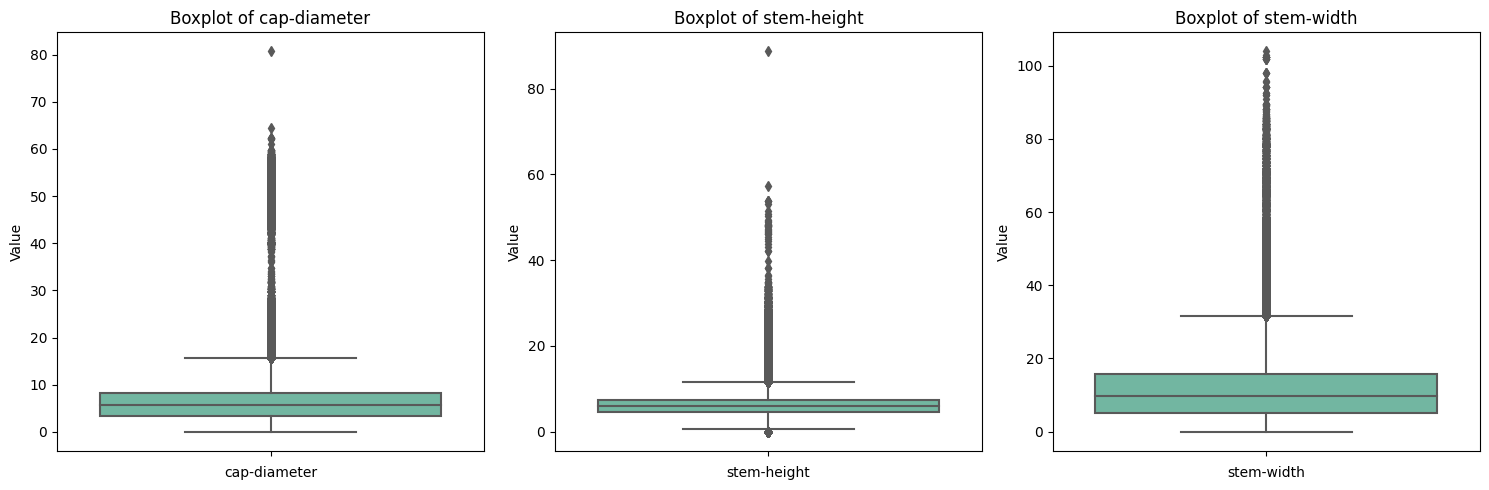

In [26]:
# Define the number of columns per row in the subplot grid
n_cols = 3

# Filter columns with more than two unique values and handle null values
filtered_cols = [col for col in train_data.select_dtypes(include=[np.number]).columns if train_data[col].nunique() > 2]

# Calculate the number of rows needed
n_rows = (len(filtered_cols) + n_cols - 1) // n_cols

# Create a figure and axes with the calculated number of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each filtered column and create a boxplot
for i, col in enumerate(filtered_cols):
    sns.boxplot(y=train_data[col].dropna(), ax=axes[i], palette=['#66c2a5'])  # Drop null values for plotting
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Value')

# Remove any extra empty subplots if the number of columns doesn't divide evenly
for j in range(len(filtered_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [27]:
# Define numerical features
numerical_features = train_data.select_dtypes(include=[np.number]).columns

# Define a function to find outliers based on IQR
def find_outliers(df):
    outliers = {}
    imputed_df = df.copy()
    for col in df.columns:
        v = df[col]
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr  
        upper_bound = q3 + 1.5 * iqr  
        outliers_count = ((v < lower_bound) | (v > upper_bound)).sum()
        perc = outliers_count * 100.0 / len(df)
        outliers[col] = (perc, outliers_count)
        print(f"Column {col} outliers = {perc:.2f}% ({outliers_count} out of {len(df)})")

    return outliers

# Find outliers in the DataFrame
find_outliers(train_data[numerical_features])


Column cap-diameter outliers = 2.48% (78814 out of 3177408)
Column stem-height outliers = 4.32% (137380 out of 3177408)
Column stem-width outliers = 2.14% (68094 out of 3177408)


{'cap-diameter': (2.4804494732813667, 78814),
 'stem-height': (4.323649968779584, 137380),
 'stem-width': (2.1430675569520816, 68094)}

# **Label Encoding**

In [28]:
categorical_cols = train_data.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_cols:
    if col != 'class':
        le = LabelEncoder()
        
        # Combine train and test data for fitting
        combined_data = pd.concat([train_data[col], test_data[col]], axis=0).reset_index(drop=True)
        
        # Fit the label encoder
        le.fit(combined_data)
        
        # Transform train and test data
        train_data[col] = le.transform(train_data[col])
        test_data[col] = le.transform(test_data[col])
        
        label_encoders[col] = le


train_data['class'] = train_data['class'].replace({'e': 1, 'p': 0})

# **Hyperparameter Tuning- Optuna**

In [29]:
y = train_data['class']
X = train_data.drop(columns=['class'])

use_gpu = False  # Set to False if you want to use CPU

In [30]:
# Hyperparameter tuning function
def objective(trial, model_class, X, y, use_gpu=False):
    if model_class == XGBClassifier:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.15),
            'max_depth': trial.suggest_int('max_depth', 10, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 10),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.7),
            'random_state': 42,
            'tree_method': 'gpu_hist' if use_gpu else 'hist'
        }
        model = model_class(**params, objective='binary:logistic')

    elif model_class == LGBMClassifier:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.06, 0.1),
            'max_depth': trial.suggest_int('max_depth', 4, 7),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 50, 100),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.7),
            'random_state': 42,
            'device': 'gpu' if use_gpu else 'cpu'
        }
        model = model_class(**params, objective='binary')

    elif model_class == CatBoostClassifier:
        params = {
            'iterations': trial.suggest_int('iterations', 2500, 3500),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
            'depth': trial.suggest_int('depth', 7, 11),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 1.0),
            'random_seed': 42,
            'task_type': 'GPU' if use_gpu else 'CPU'
        }
        model = model_class(**params, loss_function='Logloss', eval_metric='MCC', verbose=0)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    mcc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
#             ('scaler', StandardScaler()),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        mcc_scores.append(matthews_corrcoef(y_val, y_pred))

    return np.mean(mcc_scores)

def tune_hyperparameters(X, y, model_class, n_trials=20, use_gpu=False):
    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(lambda trial: objective(trial, model_class, X, y, use_gpu=use_gpu), n_trials=n_trials)
    return study.best_params


In [31]:
# Train the final models with the best parameters and print MCC for train predictions
def train_and_evaluate(model_class, params, X, y):
    model = model_class(**params)
    model.fit(X, y)
    y_pred = model.predict(X)
    mcc = matthews_corrcoef(y, y_pred)
    print(f'MCC on train data for {model_class.__name__}: {mcc}')
    return model

# **XGBoost**

In [32]:
# Tune hyperparameters for each model
xgb_params = tune_hyperparameters(X, y, XGBClassifier, n_trials=20, use_gpu=use_gpu)

# Train the final models with the best parameters
xgb_model = train_and_evaluate(XGBClassifier, xgb_params, X, y)

# Make predictions on test data
xgb_preds = xgb_model.predict(test_data)

# Convert predictions back to original labels
xgb_preds = np.where(xgb_preds > 0.5, 'e', 'p')


[I 2024-08-02 16:24:47,562] A new study created in memory with name: no-name-b48b8bb8-1143-4c72-a23a-1b5f098f889e
[I 2024-08-02 16:28:29,619] Trial 0 finished with value: 0.982050769044703 and parameters: {'n_estimators': 109, 'learning_rate': 0.09506232670757553, 'max_depth': 11, 'min_child_weight': 6, 'colsample_bytree': 0.6532157143476851}. Best is trial 0 with value: 0.982050769044703.
[I 2024-08-02 16:37:05,838] Trial 1 finished with value: 0.9832435871679246 and parameters: {'n_estimators': 332, 'learning_rate': 0.12905683040931587, 'max_depth': 10, 'min_child_weight': 7, 'colsample_bytree': 0.610814899923303}. Best is trial 1 with value: 0.9832435871679246.
[I 2024-08-02 16:50:01,569] Trial 2 finished with value: 0.9834280123388925 and parameters: {'n_estimators': 455, 'learning_rate': 0.08892929629098327, 'max_depth': 12, 'min_child_weight': 7, 'colsample_bytree': 0.6486388710442174}. Best is trial 2 with value: 0.9834280123388925.
[I 2024-08-02 16:59:49,808] Trial 3 finished w

MCC on train data for XGBClassifier: 0.9859822242208612


# **LGBM**

In [33]:
# # Tune hyperparameters for each model
# lgbm_params = tune_hyperparameters(X, y, LGBMClassifier, n_trials=50, use_gpu=use_gpu)

# # Train the final models with the best parameters
# lgbm_model = train_and_evaluate(LGBMClassifier, lgbm_params, X, y)

# # Make predictions on test data
# lgbm_preds = lgbm_model.predict(test_data)

# # Convert predictions back to original labels
# lgbm_preds = np.where(lgbm_preds > 0.5, 'e', 'p')


# **CatBoost**

In [34]:
# # Tune hyperparameters for each model
# catboost_params = tune_hyperparameters(X, y, CatBoostClassifier, n_trials=50, use_gpu=use_gpu)

# # Train the final models with the best parameters
# catboost_model = train_and_evaluate(CatBoostClassifier, catboost_params, X, y)

# # Make predictions on test data
# catboost_preds = catboost_model.predict(test_data)

# # Convert predictions back to original labels
# catboost_preds = np.where(catboost_preds > 0.5, 'e', 'p')


# **Prediction**

In [35]:
# Create a submission DataFrame for each model
submission = pd.DataFrame({
    'id': test_ids,
    'class': xgb_preds
})

# Save the predictions to CSV files
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the predictions
print("Predictions:")
print(submission.head(10))

Predictions:
        id class
0  3116945     e
1  3116946     p
2  3116947     p
3  3116948     p
4  3116949     e
5  3116950     e
6  3116951     e
7  3116952     p
8  3116953     p
9  3116954     e
